In [ ]:
# @title Copyright & License (click to expand)
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Supervised Fine Tuning with Gemini 2.0 Flash for Image Captioning

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/supervised_finetuning_using_gemini_on_image_data.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Ftuning%2Fsupervised_finetuning_using_gemini_on_image_data.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/tuning/supervised_finetuning_using_gemini_on_image_data.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/supervised_finetuning_using_gemini_on_image_data.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<b>Share to:</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/supervised_finetuning_using_gemini_on_image_data.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn logo">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/supervised_finetuning_using_gemini_on_image_data.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky logo">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/supervised_finetuning_using_gemini_on_image_data.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/5a/X_icon_2.svg" alt="X logo">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/supervised_finetuning_using_gemini_on_image_data.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit logo">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/supervised_finetuning_using_gemini_on_image_data.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook logo">
</a>            

| Author(s) |
| --- |
| [Deepak Moonat](https://github.com/dmoonat) |

## Overview

**Gemini** is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the various Gemini models, such as Gemini 2.0 Pro/Flash, Gemini 1.5 Pro/Flash, Gemini 1.0 Pro/Flash and more.

This notebook demonstrates how to fine-tune the Gemini 2.0 Flash generative model using the Vertex AI Supervised Tuning feature. Supervised Tuning allows you to use your own training data to further refine the base model's capabilities towards your specific tasks.


Supervised Tuning uses labeled examples to tune a model. Each example demonstrates the output you want from your text model during inference.

First, ensure your training data is of high quality, well-labeled, and directly relevant to the target task. This is crucial as low-quality data can adversely affect the performance and introduce bias in the fine-tuned model.
- Training: Experiment with different configurations to optimize the model's performance on the target task.
- Evaluation:
  - Metric: Choose appropriate evaluation metrics that accurately reflect the success of the fine-tuned model for your specific task
  - Evaluation Set: Use a separate set of data to evaluate the model's performance

### Objective

In this tutorial, you will learn how to use `Vertex AI` to tune a `Gemini 2.0 Flash` model.


This tutorial uses the following Google Cloud ML services:

- `Vertex AI`


The steps performed include:

- Prepare and load the dataset
- Load the `gemini-2.0-flash-001` model
- Evaluate the model before tuning
- Tune the model.
  - This will automatically create a Vertex AI endpoint and deploy the model to it
- Evaluate the model after tuning
- Make a prediction using tuned model.

### Dataset

Dataset used in this notebook is about image captioning. [Reference](https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma#download_the_model_checkpoint)

```
Licensed under the Creative Commons Attribution 4.0 License
```

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

In [1]:
%pip install --upgrade --user --quiet google-cloud-aiplatform jsonlines rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 50.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [2]:
# Automatically restart kernel after installs so that your environment can access the new packages
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [1]:
PROJECT_ID = "[YOUR_PROJECT_ID]"  # @param {type:"string"}
# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [2]:
REGION = "us-central1"  # @param {type:"string"}

#### Bucket


In [3]:
BUCKET_NAME = "[YOUR_BUCKET_NAME]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Authenticate your notebook environment**

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.

In [4]:
from google.colab import auth

auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Import libraries

In [5]:
import io
import time

# For fine tuning Gemini model.
import google.cloud.aiplatform as aiplatform
# For data handling.
import jsonlines
import pandas as pd
# For Google Cloud Storage service.
from google.cloud import storage
# For visualization.
from PIL import Image
# For evaluation.
from rouge_score import rouge_scorer
from tqdm import tqdm
from vertexai.preview.generative_models import (GenerationConfig,
                                                GenerativeModel, Part)
from vertexai.preview.tuning import sft

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [6]:
aiplatform.init(project=PROJECT_ID, location=REGION)

## Prepare Multimodal Dataset

The dataset used to tune a foundation model needs to include examples that align with the task that you want the model to perform.

Note:
- Only support images and text as input, and text only as output.
- Maximum 16 Images per tuning example.
- Maximum image file size: 20MB
- Image needs to be in `jpeg` or `png` format. Supported mimetypes: `image/jpeg` and `image/png`

Input is a jsonl file with each json string being on one line.
Each json instance have the format (Expanded for clarity):
```
{
   "contents":[
      {
         "role":"user",  # This indicate input content
         "parts":[ # Interleaved image and text, could be in any order.
            {
               "fileData":{ # FileData needs to be reference to image file in gcs. No inline data.
                  "mimeType":"image/jpeg", # Provide the mimeType about this image
                  "fileUri":"gs://path/to/image_uri"
               }
            }
            {
               "text":"What is in this image?"
            }
         ]
      },
      {
         "role":"model", # This indicate target content
         "parts":[ # text only
            {
               "text":"Something about this image."
            }
         ]
      } # Single turn input and response.
   ]
}
```

Example:
```
{
   "contents":[
      {
         "role":"user",
         "parts":[
            {
               "fileData":{
                  "mimeType":"image/jpeg",
                  "fileUri":"gs://bucketname/data/vision_data/task/image_description/image/1.jpeg"
               }
            },
            {
               "text":"Describe this image that captures the essence of it."
            }
         ]
      },
      {
         "role":"model",
         "parts":[
            {
               "text":"A person wearing a pink shirt and a long-sleeved shirt with a large cuff, ...."
            }
         ]
      }
   ]
}
```


### Data files


Data used in this notebook is present in the public Cloud Storage(GCS) bucket, `gs://longcap100`.

Sample:

> {"prefix": "", "suffix": "A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge. The hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is rolled up. The shadow of the hand is on the wall.", "image": "91.jpeg"}



- `data_train90.jsonl`: Contains training samples in json lines as shown above
- `data_val10.jsonl`: Contains validation samples in json lines as shown above
- `images`: Contains 100 images, training and validation data

To run a tuning job, you need to upload one or more datasets to a Cloud Storage bucket. You can either create a new Cloud Storage bucket or use an existing one to store dataset files. The region of the bucket doesn't matter, but we recommend that you use a bucket that's in the same Google Cloud project where you plan to tune your model.

### Create a Cloud Storage bucket

- Create a storage bucket to store intermediate artifacts such as datasets.

- Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.


In [7]:
!gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://gemini-image-finetuning-001/...


### Copy images to specified Bucket

In [8]:
!gsutil -m -q cp -n -r gs://longcap100/*.jpeg {BUCKET_URI}/images/

- Download the training and validation dataset jsonlines files from the bucket.

In [9]:
!gsutil -m -q cp -n -r gs://longcap100/data_train90.jsonl .

In [10]:
!gsutil -m -q cp -n -r gs://longcap100/data_val10.jsonl .

### Prepare dataset for Training and Evaluation

- Utility function to save json instances into jsonlines format

In [11]:
def save_jsonlines(file, instances):
    """
    Saves a list of json instances to a jsonlines file.
    """
    with jsonlines.open(file, mode="w") as writer:
        writer.write_all(instances)

- Below function converts the dataset into Gemini-1.5 tuning format

In [12]:
task_prompt = "Describe this image in detail that captures the essence of it."

In [13]:
def create_tuning_samples(file_path):
    """
    Creates tuning samples from a file.
    """
    with jsonlines.open(file_path) as reader:
        instances = []
        for obj in reader:
            instance = {
                "contents": [
                    {
                        "role": "user",  # This indicate input content
                        "parts": [  # Interleaved image and text, could be in any order.
                            {
                                "fileData": {  # FileData needs to be reference to image file in gcs. No inline data.
                                    "mimeType": "image/jpeg",  # Provide the mimeType about this image
                                    "fileUri": f"{BUCKET_URI}/images/{obj['image']}",
                                }
                            },
                            {"text": task_prompt},
                        ],
                    },
                    {
                        "role": "model",  # This indicate target content
                        "parts": [{"text": obj["suffix"]}],  # text only
                    },  # Single turn input and response.
                ]
            }
            instances.append(instance)
    return instances

- Training data

In [14]:
train_file_path = "data_train90.jsonl"
train_instances = create_tuning_samples(train_file_path)
# save the training instances to jsonl file
save_jsonlines("train.jsonl", train_instances)

In [15]:
train_instances[0]

{'contents': [{'role': 'user',
   'parts': [{'fileData': {'mimeType': 'image/jpeg',
      'fileUri': 'gs://gemini-image-finetuning-001/images/1.jpeg'}},
    {'text': 'Describe this image in detail that captures the essence of it.'}]},
  {'role': 'model',
   'parts': [{'text': "A brown and white cat with a red collar looks to the left, its eyes shining yellow. The cat's fur is long and silky, and its whiskers are long and prominent. The cat's nose is pink, and its ears are pointy. The cat's eyes are yellow, and its fur is brown and white. The cat is standing in the dark, and its head is turned to the side."}]}]}

In [16]:
# save the training data to GCS bucket
!gsutil cp train.jsonl {BUCKET_URI}/train/

Copying file://train.jsonl [Content-Type=application/octet-stream]...
/ [1 files][ 51.3 KiB/ 51.3 KiB]                                                
Operation completed over 1 objects/51.3 KiB.                                     


- Validation data

In [17]:
val_file_path = "data_val10.jsonl"
val_instances = create_tuning_samples(val_file_path)
# save the training instances to jsonl file
save_jsonlines("val.jsonl", val_instances)

In [18]:
val_instances[0]

{'contents': [{'role': 'user',
   'parts': [{'fileData': {'mimeType': 'image/jpeg',
      'fileUri': 'gs://gemini-image-finetuning-001/images/91.jpeg'}},
    {'text': 'Describe this image in detail that captures the essence of it.'}]},
  {'role': 'model',
   'parts': [{'text': 'A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge. The hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is rolled up. The shadow of the hand is on the wall.'}]}]}

In [19]:
# save the validation data to GCS bucket
!gsutil cp val.jsonl {BUCKET_URI}/val/

Copying file://val.jsonl [Content-Type=application/octet-stream]...
/ [1 files][  5.2 KiB/  5.2 KiB]                                                
Operation completed over 1 objects/5.2 KiB.                                      


- Below code transforms the jsonl format to following structure

`
[{'file_uri': '<GCS path for query image>',
 'ground_truth': '<Ground truth, image description'},
 ..
]
`

In [20]:
data_table = []
for instance in val_instances:
    data_table.append(
        {
            "file_uri": instance["contents"][0]["parts"][0]["fileData"]["fileUri"],
            "ground_truth": instance["contents"][1]["parts"][0]["text"],
        }
    )

In [21]:
data_table[0]

{'file_uri': 'gs://gemini-image-finetuning-001/images/91.jpeg',
 'ground_truth': 'A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge. The hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is rolled up. The shadow of the hand is on the wall.'}

- The `data_table` is converted into dataframe of two columns, file_uri and ground_truth. The `ground_truth` will be compared with the model generated output

In [22]:
val_df = pd.DataFrame(data_table)
val_df

,file_uri,ground_truth
0,gs://gemini-image-finetuning-001/images/91.jpeg,A person wearing a pink shirt and a long-sleev...
1,gs://gemini-image-finetuning-001/images/92.jpeg,A woman in a floral dress stands on a ledge. T...
2,gs://gemini-image-finetuning-001/images/93.jpeg,A woman in a red jacket and black pants with a...
3,gs://gemini-image-finetuning-001/images/94.jpeg,"A woman stands on a set of stone steps, holdin..."
4,gs://gemini-image-finetuning-001/images/95.jpeg,"A person's hand rests on a pink sweater, adorn..."
5,gs://gemini-image-finetuning-001/images/96.jpeg,"A man with long, blonde hair and a black sweat..."
6,gs://gemini-image-finetuning-001/images/97.jpeg,A white rack with hangers on it. The rack is w...
7,gs://gemini-image-finetuning-001/images/98.jpeg,A white garment hangs on a wooden hanger in a ...
8,gs://gemini-image-finetuning-001/images/99.jpeg,"A woman stands on a sidewalk, holding a black ..."
9,gs://gemini-image-finetuning-001/images/100.jpeg,"A man stands on a road, wearing a blue denim j..."


- Total `10` instances in validation data

## Visualization utils

- Function to visualize the query images stored in GCS bucket

In [25]:
# read a image bytes file present in GCS bucket


def read_image_bytes_from_gcs(bucket_name, blob_name):
    """Reads image bytes from a GCS bucket.

    Args:
      bucket_name: The name of the GCS bucket.
      blob_name: The name of the blob (file) within the bucket.

    Returns:
      The image bytes as a bytes object.
    """

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    image_bytes = blob.download_as_bytes()

    return image_bytes

## Evaluation Pre-Tuning

- Load the `gemini-2.0-flash-001` model


In [23]:
base_model = "gemini-2.0-flash-001"
generation_model = GenerativeModel(base_model)

### Generation config

- Each call that you send to a model includes parameter values that control how the model generates a response. The model can generate different results for different parameter values
- <strong>Experiment</strong> with different parameter values to get the best values for the task

Refer to the following [link](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/adjust-parameter-values) for understanding different parameters

**Prompt** is a natural language request submitted to a language model to receive a response back

Some best practices include
  - Clearly communicate what content or information is most important
  - Structure the prompt:
    - Defining the role if using one. For example, You are an experienced UX designer at a top tech company
    - Include context and input data
    - Provide the instructions to the model
    - Add example(s) if you are using them

Refer to the following [link](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/prompt-design-strategies) for prompt design strategies.

### Task

***Task prompt:***

`
"<image>, Describe this image that captures the essence of it. "
`

***Query Image (image)***


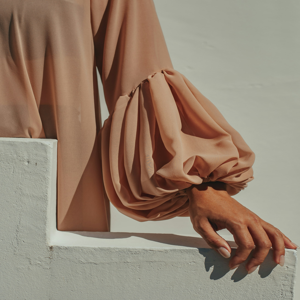

In [26]:
query_image_uri = val_instances[0]["contents"][0]["parts"][0]["fileData"]["fileUri"]
blob_name = query_image_uri.replace(f"{BUCKET_URI}/", "")
img = read_image_bytes_from_gcs(BUCKET_NAME, blob_name)

# Display image bytes using pil python library
image = Image.open(io.BytesIO(img))
resized_img = image.resize((300, 300))
display(resized_img)

- Test on single instance

In [27]:
response = generation_model.generate_content(
    contents=[
        Part.from_uri(query_image_uri, "image/jpeg"),
        "Describe this image that captures the essence of it.",
    ],
    # Optional config
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
)

print(response.text.strip())

The image features a woman's arm and hand draped over a white, stepped structure. She is wearing a long-sleeved, peach-colored blouse with a dramatically puffed sleeve that gathers at the wrist. The fabric of the blouse has a soft, textured appearance. Her hand rests gently on the edge of the structure, with her fingers slightly curled. The lighting is bright and casts strong shadows, highlighting the textures of the blouse and the structure. The overall aesthetic is clean, minimalist, and elegant.


- Ground truth

In [28]:
val_instances[0]["contents"][1]["parts"][0]["text"]

'A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge. The hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is rolled up. The shadow of the hand is on the wall.'

- Change prompt to get detailed description for the provided image

In [29]:
response = generation_model.generate_content(
    contents=[
        Part.from_uri(query_image_uri, "image/jpeg"),
        "Describe this image in detail that captures the essence of it.",
    ],
    # Optional config
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
)

print(response.text.strip())

Here's a detailed description of the image:

**Overall Impression:**

The image presents a close-up, artistic shot focusing on a woman's arm and hand, draped in a flowing, peach-colored blouse with dramatic, voluminous sleeves. The composition is clean and minimalist, emphasizing texture, light, and shadow.

**Subject Details:**

*   **Arm and Hand:** The woman's arm is positioned at an angle, with her hand resting gently on a white, textured surface. The skin tone is warm and appears smooth. Her nails are neatly manicured with a natural, nude polish.
*   **Blouse:** The blouse is the focal point, featuring a soft, peach hue. The fabric appears lightweight and slightly sheer, creating delicate folds and shadows. The sleeves are the most striking element, gathered at the wrist to create a large, balloon-like shape. The fabric drapes beautifully, adding a sense of movement and elegance.

**Background and Setting:**

*   **White Surface:** The hand rests on a white, textured surface that 

## Evaluation before model tuning

- Evaluate the Gemini model on the validation dataset before tuning it on the training dataset.

In [30]:
def get_prediction(query_image, generation_model):
    """Gets the prediction for a given instance.

    Args:
      query_image: The path to the query image.
      candidates: A list of paths to the candidate images.
      generation_model: The generation model to use for prediction.

    Returns:
      A string containing the prediction.
    """
    response = generation_model.generate_content(
        contents=[Part.from_uri(query_image, "image/jpeg"), task_prompt],
        # Optional config
        generation_config=GenerationConfig(
            temperature=0.0,
        ),
    )

    return response.text.strip()

In [31]:
def run_eval(val_df, model=generation_model):
    """Runs evaluation on the validation dataset.

    Args:
      val_df: The validation dataframe.
      generation_model: The generation model to use for evaluation.

    Returns:
      A list of predictions on val_df.
    """
    predictions = []
    for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
        try:
            prediction = get_prediction(row["file_uri"], model)
        except:
            time.sleep(30)
            prediction = get_prediction(row["file_uri"], model)
        predictions.append(prediction)
        time.sleep(1)
    return predictions

- Evaluate the Gemini model on the test dataset before tuning it on the training dataset.


<div class="alert alert-block alert-warning">
<b>⚠️ It will take ~1 min for the model to generate predictions on the provided validation dataset. ⚠️</b>
</div>

In [32]:
%%time
predictions = run_eval(val_df, model=generation_model)

100%|██████████| 10/10 [00:46<00:00,  4.61s/it]

CPU times: user 248 ms, sys: 54.6 ms, total: 303 ms
Wall time: 46.1 s


In [33]:
len(predictions)

10

In [34]:
val_df.loc[:, "basePredictions"] = predictions

In [35]:
val_df

,file_uri,ground_truth,basePredictions
0,gs://gemini-image-finetuning-001/images/91.jpeg,A person wearing a pink shirt and a long-sleev...,Here's a detailed description of the image:\n\...
1,gs://gemini-image-finetuning-001/images/92.jpeg,A woman in a floral dress stands on a ledge. T...,Here is a detailed description of the image:\n...
2,gs://gemini-image-finetuning-001/images/93.jpeg,A woman in a red jacket and black pants with a...,Here's a detailed description of the image:\n\...
3,gs://gemini-image-finetuning-001/images/94.jpeg,"A woman stands on a set of stone steps, holdin...",Here's a detailed description of the image:\n\...
4,gs://gemini-image-finetuning-001/images/95.jpeg,"A person's hand rests on a pink sweater, adorn...",Here is a detailed description of the image:\n...
5,gs://gemini-image-finetuning-001/images/96.jpeg,"A man with long, blonde hair and a black sweat...",Here's a detailed description of the image:\n\...
6,gs://gemini-image-finetuning-001/images/97.jpeg,A white rack with hangers on it. The rack is w...,Here's a detailed description of the image:\n\...
7,gs://gemini-image-finetuning-001/images/98.jpeg,A white garment hangs on a wooden hanger in a ...,Here's a detailed description of the image:\n\...
8,gs://gemini-image-finetuning-001/images/99.jpeg,"A woman stands on a sidewalk, holding a black ...",Here's a detailed description of the image:\n\...
9,gs://gemini-image-finetuning-001/images/100.jpeg,"A man stands on a road, wearing a blue denim j...",Here's a detailed description of the image:\n\...


### Evaluation metric

The type of metrics used for evaluation depends on the task that you are evaluating. The following table shows the supported tasks and the metrics used to evaluate each task:

| Task             | Metric(s)                     |
|-----------------|---------------------------------|
| Classification   | Micro-F1, Macro-F1, Per class F1 |
| Summarization    | ROUGE-L                         |
| Question Answering | Exact Match                     |
| Text Generation  | BLEU, ROUGE-L                   |


For this task, we'll using ROUGE metric.

- **Recall-Oriented Understudy for Gisting Evaluation (ROUGE)**: A metric used to evaluate the quality of automatic summaries of text. It works by comparing a generated summary to a set of reference summaries created by humans.

Now you can take the candidate and reference to evaluate the performance. In this case, ROUGE will give you:

- `rouge-1`, which measures unigram overlap
- `rouge-2`, which measures bigram overlap
- `rouge-l`, which measures the longest common subsequence

- *Recall vs. Precision*

    **Recall**, meaning it prioritizes how much of the information in the reference summaries is captured in the generated summary.

    **Precision**, which measures how much of the generated summary is relevant to the original text.

- Initialize `rouge_score` object

In [36]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

- Define function to calculate rouge score

In [37]:
def get_rouge_score(groundTruth, prediction):
    """Function to compute rouge score.

    Args:
      groundTruth: The ground truth text.
      prediction: The predicted text.
    Returns:
      The rouge score.
    """
    scores = scorer.score(target=groundTruth, prediction=prediction)
    return scores

- Single instance evaluation

In [38]:
get_rouge_score(val_df.loc[0, "ground_truth"], val_df.loc[0, "basePredictions"])

{'rouge1': Score(precision=0.1384083044982699, recall=0.6451612903225806, fmeasure=0.22792022792022792),
 'rouge2': Score(precision=0.04513888888888889, recall=0.21311475409836064, fmeasure=0.07449856733524356),
 'rougeL': Score(precision=0.10726643598615918, recall=0.5, fmeasure=0.17663817663817666)}

In [39]:
def calculate_metrics(val_df, prediction_col="basePredictions"):
    """Function to compute rouge scores for all instances in the validation dataset.
    Args:
      val_df: The validation dataframe.
      prediction_col: The column name of the predictions.
    Returns:
      A dataframe containing the rouge scores.
    """
    records = []
    for row, instance in val_df.iterrows():
        scores = get_rouge_score(instance["ground_truth"], instance[prediction_col])
        records.append(
            {
                "rouge1_precision": scores.get("rouge1").precision,
                "rouge1_recall": scores.get("rouge1").recall,
                "rouge1_fmeasure": scores.get("rouge1").fmeasure,
                "rouge2_precision": scores.get("rouge2").precision,
                "rouge2_recall": scores.get("rouge2").recall,
                "rouge2_fmeasure": scores.get("rouge2").fmeasure,
                "rougeL_precision": scores.get("rougeL").precision,
                "rougeL_recall": scores.get("rougeL").recall,
                "rougeL_fmeasure": scores.get("rougeL").fmeasure,
            }
        )
    metrics = pd.DataFrame(records)
    return metrics

In [40]:
evaluation_df_stats = calculate_metrics(val_df, prediction_col="basePredictions")
evaluation_df_stats

,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
0,0.138408,0.645161,0.227920,0.045139,0.213115,0.074499,0.107266,0.500000,0.176638
1,0.240196,0.859649,0.375479,0.083744,0.303571,0.131274,0.171569,0.614035,0.268199
2,0.096234,0.821429,0.172285,0.050420,0.444444,0.090566,0.087866,0.750000,0.157303
3,0.191406,0.777778,0.307210,0.050980,0.209677,0.082019,0.140625,0.571429,0.225705
4,0.104247,0.692308,0.181208,0.027132,0.184211,0.047297,0.077220,0.512821,0.134228
5,0.086687,0.682927,0.153846,0.015528,0.125000,0.027624,0.055728,0.439024,0.098901
6,0.195489,0.702703,0.305882,0.053030,0.194444,0.083333,0.142857,0.513514,0.223529
7,0.206780,0.813333,0.329730,0.068027,0.270270,0.108696,0.149153,0.586667,0.237838
8,0.207317,0.653846,0.314815,0.057143,0.181818,0.086957,0.121951,0.384615,0.185185
9,0.198381,0.710145,0.310127,0.065041,0.235294,0.101911,0.133603,0.478261,0.208861


In [41]:
print("Mean rougeL_precision is", evaluation_df_stats.rougeL_precision.mean())
print("Mean rougeL_recall is", evaluation_df_stats.rougeL_recall.mean())
print("Mean rougeL_fmeasure is", evaluation_df_stats.rougeL_fmeasure.mean())

Mean rougeL_precision is 0.11878379472320107
Mean rougeL_recall is 0.5350364996573067
Mean rougeL_fmeasure is 0.19163885913967355


## Fine-tune the model

When you run a supervised fine-tuning job, the model learns additional parameters that help it encode the necessary information to perform the desired task or learn the desired behavior. These parameters are used during inference. The output of the tuning job is a new model that combines the newly learned parameters with the original model.

**Tuning Job parameters**

- `source_model`: Specifies the base Gemini model version you want to fine-tune.
- `train_dataset`: Path to your training data in JSONL format.


 *Optional parameters*
 - `validation_dataset`: If provided, this data is used to evaluate the model during tuning.
 - `tuned_model_display_name`: Display name for the tuned model.

 *Hyperparameters*
 - `epochs`: The number of training epochs to run.
 - `learning_rate_multiplier`: A value to scale the learning rate during training.
 - `adapter_size` : Gemini 2.0 Flash supports Adapter length [1, 4], default value is 4.


**Note: The default hyperparameter settings are optimized for optimal performance based on rigorous testing and are recommended for initial use. Users may customize these parameters to address specific performance requirements.**

In [42]:
tuned_model_display_name = "[DISPLAY NAME FOR TUNED MODEL]"  # @param {type:"string"}

sft_tuning_job = sft.train(
    source_model=base_model,
    train_dataset=f"{BUCKET_URI}/train/train.jsonl",
    # Optional:
    validation_dataset=f"{BUCKET_URI}/val/val.jsonl",
    tuned_model_display_name=tuned_model_display_name,
)

INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob
INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/801452371447/locations/us-central1/tuningJobs/7625858624690061312
INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:
INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/801452371447/locations/us-central1/tuningJobs/7625858624690061312')
INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/7625858624690061312?project=801452371447


In [43]:
job_name = sft_tuning_job.to_dict()["name"]
job_name

'projects/801452371447/locations/us-central1/tuningJobs/7625858624690061312'

In [44]:
sft_tuning_job.to_dict()

{'name': 'projects/801452371447/locations/us-central1/tuningJobs/7625858624690061312',
 'tunedModelDisplayName': 'gemini-2.0-image-fine-tuning-test',
 'baseModel': 'gemini-2.0-flash-001',
 'supervisedTuningSpec': {'trainingDatasetUri': 'gs://gemini-image-finetuning-001/train/train.jsonl',
  'validationDatasetUri': 'gs://gemini-image-finetuning-001/val/val.jsonl',
  'hyperParameters': {}},
 'state': 'JOB_STATE_PENDING',
 'createTime': '2025-03-10T16:49:55.096893Z',
 'updateTime': '2025-03-10T16:49:55.096893Z'}

**Note: Tuning time depends on several factors, such as training data size, number of epochs, learning rate multiplier, etc.**

<div class="alert alert-block alert-warning">
<b>⚠️ It will take 30-40 mins for the model tuning job to complete on the provided dataset and set configurations/hyperparameters. ⚠️</b>
</div>

In [45]:
%%time
# Wait for job completion
while not sft_tuning_job.refresh().has_ended:
    time.sleep(60)

CPU times: user 10.2 s, sys: 1.81 s, total: 12 s
Wall time: 30min 29s


In [46]:
sft_tuning_job.to_dict()

{'name': 'projects/801452371447/locations/us-central1/tuningJobs/7625858624690061312',
 'tunedModelDisplayName': 'gemini-2.0-image-fine-tuning-test',
 'baseModel': 'gemini-2.0-flash-001',
 'supervisedTuningSpec': {'trainingDatasetUri': 'gs://gemini-image-finetuning-001/train/train.jsonl',
  'validationDatasetUri': 'gs://gemini-image-finetuning-001/val/val.jsonl',
  'hyperParameters': {'epochCount': '40',
   'learningRateMultiplier': 0.5,
   'adapterSize': 'ADAPTER_SIZE_FOUR'}},
 'state': 'JOB_STATE_SUCCEEDED',
 'createTime': '2025-03-10T16:49:55.096893Z',
 'startTime': '2025-03-10T16:49:55.133726Z',
 'endTime': '2025-03-10T17:20:08.721930Z',
 'updateTime': '2025-03-10T17:20:08.721930Z',
 'experiment': 'projects/801452371447/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20250310095028168551',
 'tunedModel': {'model': 'projects/801452371447/locations/us-central1/models/4596184003987374080@1',
  'endpoint': 'projects/801452371447/locations/us-central1/endpoints/4

## Evaluation Post-tuning

- Evaluate the Gemini model on the validation dataset with tuned model.

In [47]:
tuning_job = sft.SupervisedTuningJob(job_name)

# tuned model endpoint name
tuned_model_endpoint_name = tuning_job.tuned_model_endpoint_name

tuned_model = GenerativeModel(tuned_model_endpoint_name)

In [48]:
# Get experiment resource name from tuning job.
experiment_name = tuning_job.experiment.resource_name
experiment_name

'projects/801452371447/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20250310095028168551'

In [49]:
# tuned model name
tuned_model_name = tuning_job.tuned_model_name
tuned_model_name

'projects/801452371447/locations/us-central1/models/4596184003987374080@1'

- Get a prediction from base model

In [50]:
response = generation_model.generate_content(
    contents=[Part.from_uri(query_image_uri, "image/jpeg"), task_prompt],
    # Optional config
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
)

print(response.text.strip())

Here's a detailed description of the image:

**Overall Impression:** The image presents a close-up, artistic composition focusing on texture, form, and light. It evokes a sense of elegance and understated luxury.

**Subject:** The primary subject is a woman's arm and hand, adorned with a flowing, peach-colored blouse featuring a dramatically puffed sleeve. The hand rests gently on a white, textured surface.

**Color Palette:** The color scheme is muted and warm. The peach of the blouse contrasts subtly with the cool white of the background. The skin tone of the hand adds another layer of warmth.

**Lighting:** The lighting is strong and directional, creating deep shadows that emphasize the folds and textures of the fabric and the surface. The light source appears to be coming from the side, casting long shadows from the hand and sleeve.

**Composition:** The composition is carefully arranged. The arm and sleeve are positioned diagonally, leading the eye through the image. The hand is p

- Get a prediction from tuned model

In [51]:
response = tuned_model.generate_content(
    contents=[Part.from_uri(query_image_uri, "image/jpeg"), task_prompt],
    # Optional config
    generation_config=GenerationConfig(
        temperature=0.0,
    ),
)

print(response.text.strip())

A woman wearing a long-sleeved shirt stands next to a white wall. The shirt is pink with puffy sleeves and a relaxed fit. The woman's hand is on the wall, and her fingers are extended. The wall is white, and the sky is clear. The woman's shirt is flowing, and her sleeves are puffed.


- Evaluate the tuned model on entire validation set

<div class="alert alert-block alert-warning">
<b>⚠️ It will take ~1 min for the model to generate predictions on the provided validation dataset. ⚠️</b>
</div>

In [52]:
%%time
predictions_tuned = run_eval(val_df, model=tuned_model)

100%|██████████| 10/10 [00:47<00:00,  4.77s/it]

CPU times: user 322 ms, sys: 63.2 ms, total: 386 ms
Wall time: 47.7 s


In [53]:
val_df.loc[:, "tunedPredictions"] = predictions_tuned

In [54]:
evaluation_df_post_tuning_stats = calculate_metrics(
    val_df, prediction_col="tunedPredictions"
)
evaluation_df_post_tuning_stats

,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure
0,0.508772,0.467742,0.487395,0.196429,0.180328,0.188034,0.368421,0.338710,0.352941
1,0.510417,0.859649,0.640523,0.336842,0.571429,0.423841,0.343750,0.578947,0.431373
2,0.293333,0.785714,0.427184,0.189189,0.518519,0.277228,0.240000,0.642857,0.349515
3,0.576923,0.714286,0.638298,0.350649,0.435484,0.388489,0.410256,0.507937,0.453901
4,0.325000,0.666667,0.436975,0.139241,0.289474,0.188034,0.237500,0.487179,0.319328
5,0.437500,0.682927,0.533333,0.158730,0.250000,0.194175,0.296875,0.463415,0.361905
6,0.575000,0.621622,0.597403,0.230769,0.250000,0.240000,0.375000,0.405405,0.389610
7,0.532468,0.546667,0.539474,0.223684,0.229730,0.226667,0.389610,0.400000,0.394737
8,0.649351,0.641026,0.645161,0.381579,0.376623,0.379085,0.415584,0.410256,0.412903
9,0.468085,0.637681,0.539877,0.215054,0.294118,0.248447,0.351064,0.478261,0.404908


- Improvement

In [55]:
evaluation_df_post_tuning_stats.rougeL_precision.mean()

0.3428061097870029

In [56]:
improvement = round(
    (
        (
            evaluation_df_post_tuning_stats.rougeL_precision.mean()
            - evaluation_df_stats.rougeL_precision.mean()
        )
        / evaluation_df_stats.rougeL_precision.mean()
    )
    * 100,
    2,
)
print(
    f"Model tuning has improved the rougeL_precision by {improvement}% (result might differ based on each tuning iteration)"
)

Model tuning has improved the rougeL_precision by 188.6% (result might differ based on each tuning iteration)


In [57]:
# Save predicitons
predictions_all = val_df.to_csv("validation_pred.csv", index=False)

## Conclusion

Performance could be further improved:
- By adding more training samples. In general, improve your training data quality and/or quantity towards getting a more diverse and comprehensive dataset for your task
- By tuning the hyperparameters, such as epochs, learning rate multiplier or adapter size
  - To find the optimal number of epochs for your dataset, we recommend experimenting with different values. While increasing epochs can lead to better performance, it's important to be mindful of overfitting, especially with smaller datasets. If you see signs of overfitting, reducing the number of epochs can help mitigate the issue
- You may try different prompt structures/formats and opt for the one with better performance

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.


Otherwise, you can delete the individual resources you created in this tutorial.

Refer to this [instructions](https://cloud.google.com/vertex-ai/docs/tutorials/image-classification-custom/cleanup#delete_resources) to delete the resources from console.

In [58]:
# Delete Experiment.
delete_experiments = True
if delete_experiments:
    experiments_list = aiplatform.Experiment.list()
    for experiment in experiments_list:
        if experiment.resource_name == experiment_name:
            print(experiment.resource_name)
            experiment.delete()
            break

print("***" * 10)

# Delete Endpoint.
delete_endpoint = True
# If force is set to True, all deployed models on this
# Endpoint will be first undeployed.
if delete_endpoint:
    for endpoint in aiplatform.Endpoint.list():
        if endpoint.resource_name == tuned_model_endpoint_name:
            print(endpoint.resource_name)
            endpoint.delete(force=True)
            break

print("***" * 10)

# Delete Cloud Storage Bucket.
delete_bucket = True
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI

projects/801452371447/locations/us-central1/metadataStores/default/contexts/tuning-experiment-20250310095028168551


Experiment run tuning-experiment-run-20250310095028168551 skipped backing tensorboard run deletion.
To delete backing tensorboard run, execute the following:
tensorboard_run_artifact = aiplatform.metadata.artifact.Artifact(artifact_name=f"tuning-experiment-20250310095028168551-tuning-experiment-run-20250310095028168551-tb-run")
tensorboard_run_resource = aiplatform.TensorboardRun(tensorboard_run_artifact.metadata["resourceName"])
tensorboard_run_resource.delete()
tensorboard_run_artifact.delete()


******************************
projects/801452371447/locations/us-central1/endpoints/4867904113536401408
******************************
Removing gs://gemini-image-finetuning-001/images/1.jpeg#1741624802840929...
Removing gs://gemini-image-finetuning-001/images/10.jpeg#1741624802830831...
Removing gs://gemini-image-finetuning-001/images/11.jpeg#1741624803148393...
Removing gs://gemini-image-finetuning-001/images/100.jpeg#1741624803042192...
Removing gs://gemini-image-finetuning-001/images/12.jpeg#1741624803392900...
Removing gs://gemini-image-finetuning-001/images/13.jpeg#1741624803981585...
Removing gs://gemini-image-finetuning-001/images/14.jpeg#1741624803633363...
Removing gs://gemini-image-finetuning-001/images/15.jpeg#1741624804151784...
Removing gs://gemini-image-finetuning-001/images/16.jpeg#1741624803833310...
Removing gs://gemini-image-finetuning-001/images/17.jpeg#1741624804248931...
Removing gs://gemini-image-finetuning-001/images/18.jpeg#1741624803571439...
Removing gs://gem